In [1]:
#Regression Intro, quandl.com
import pandas as pd
import quandl
import math, datetime
import numpy as np
#svm, support vector machine, can be used to do regression
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import pickle
style.use("ggplot")

#quandl.get() default returns a pandas dataframe
df=quandl.get("WIKI/GOOGL")
print (df.head())

              Open    High     Low    Close      Volume  Ex-Dividend  \
Date                                                                   
2004-08-19  100.01  104.06   95.96  100.335  44659000.0          0.0   
2004-08-20  101.01  109.08  100.50  108.310  22834300.0          0.0   
2004-08-23  110.76  113.48  109.05  109.400  18256100.0          0.0   
2004-08-24  111.24  111.60  103.57  104.870  15247300.0          0.0   
2004-08-25  104.76  108.00  103.88  106.000   9188600.0          0.0   

            Split Ratio  Adj. Open  Adj. High   Adj. Low  Adj. Close  \
Date                                                                   
2004-08-19          1.0  50.159839  52.191109  48.128568   50.322842   
2004-08-20          1.0  50.661387  54.708881  50.405597   54.322689   
2004-08-23          1.0  55.551482  56.915693  54.693835   54.869377   
2004-08-24          1.0  55.792225  55.972783  51.945350   52.597363   
2004-08-25          1.0  52.542193  54.167209  52.100830   53.1

In [2]:
df=df[["Adj. Open", "Adj. High", "Adj. Low", "Adj. Close", "Adj. Volume"]]

In [3]:
#high-low percent change
df["HL_PCT"]=(df["Adj. High"]-df["Adj. Low"])/df["Adj. Low"]*100
df["PCT_change"]=(df["Adj. Close"]-df["Adj. Open"])/df["Adj. Open"]*100

df=df[["Adj. Close", "HL_PCT", "PCT_change", "Adj. Volume"]]
print (df.head())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume
Date                                                     
2004-08-19   50.322842  8.441017    0.324968   44659000.0
2004-08-20   54.322689  8.537313    7.227007   22834300.0
2004-08-23   54.869377  4.062357   -1.227880   18256100.0
2004-08-24   52.597363  7.753210   -5.726357   15247300.0
2004-08-25   53.164113  3.966115    1.183658    9188600.0


In [4]:
forecast_col="Adj. Close"
df.fillna(-99999, inplace=True) 
#predict 1% of the dataframe
forecast_out=int(math.ceil(0.01*len(df)))


In [5]:
#Here we're taking 0.01 or 1% of the length of all the rows within the dataframe. Each row in the dataFrame is representative of a day
#in the life of the stock. So if the stock has been trading for 365 days, there will be 365 rows in the dataFrame. 1% of 365 is 
#3.65 days which is then rounded up by the math.ceil function to 4 days. The 4 days will be the forecast _out variable which is 
#the variable that used to shift the Adj.Close price column in the dataFame up by 4. In other words, if you were standing at day
#1 of the stock when it was first traded, the prediction or the 'label' from his algorithm would tell you that at day 4, your 
#stock will be valued at the amount of the close as taken on day 4 from actual data. T
#his isn't totally useful information since you can look at the Adj.Close column on day 4 to get back to the label info on day 1. 
#This is really all done to build a training set so that the machine can learn from the trend.
#It means forecast out variable will have NA values after day 361?
#Yes, precisely that's true. But here since dropna is being used, the NA values are not displayed when df.tail() is printed
#an example of shift function: http://stackoverflow.com/questions/20095673/python-shift-column-in-pandas-dataframe-up-by-one

df["label"]=df[forecast_col].shift(-forecast_out)

print (df.head())
print (df.tail())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume      label
Date                                                                
2004-08-19   50.322842  8.441017    0.324968   44659000.0  69.399229
2004-08-20   54.322689  8.537313    7.227007   22834300.0  68.752232
2004-08-23   54.869377  4.062357   -1.227880   18256100.0  69.639972
2004-08-24   52.597363  7.753210   -5.726357   15247300.0  69.078238
2004-08-25   53.164113  3.966115    1.183658    9188600.0  67.839414
            Adj. Close    HL_PCT  PCT_change  Adj. Volume  label
Date                                                            
2016-12-19      812.50  1.456805    0.397885    1257536.0    NaN
2016-12-20      815.20  0.676942    0.224990    1253123.0    NaN
2016-12-21      812.20  1.319091   -0.431521    1450499.0    NaN
2016-12-22      809.68  0.625287    0.071685    1123874.0    NaN
2016-12-23      807.80  0.727801   -0.025990     762046.0    NaN


In [6]:
#usually features is used as X, and label is y
#drop axis=1 denotes that we are referring to a column, not a row: 
#http://chrisalbon.com/python/pandas_dropping_column_and_rows.html
X=np.array(df.drop(["label"], 1))
X=preprocessing.scale(X)
X_lately=X[-forecast_out:]
X=X[forecast_out:]
df.dropna(inplace=True)
y=np.array(df["label"])
#http://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/
#http://scikit-learn.org/stable/modules/preprocessing.html

print (len(X), len(y))


3079 3079


c:\users\lisa\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\preprocessing\data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [10]:
X_train, X_test, y_train, y_test=cross_validation.train_test_split(X, y, test_size=0.2)
#https://pythontips.com/2013/08/02/what-is-pickle-in-python/
clf=LinearRegression () #n_jobs=-1 means using all CPUs
clf.fit(X_train, y_train)
with open("linearregression.pickle", "wb") as f:
    pickle.dump(clf, f)
pickle_in = open("linearregression.pickle", "rb")
clf=pickle.load(pickle_in)
    
accuracy=clf.score(X_test, y_test)
print (accuracy)
#accuracy of forecasting 32 days in advance
print (forecast_out)


clf=svm.SVR()
clf.fit(X_train, y_train)
accuracy=clf.score(X_test, y_test)
print (accuracy)

clf=svm.SVR(kernel="poly")
clf.fit(X_train, y_train)
accuracy=clf.score(X_test, y_test)
print (accuracy)

1.0
32
0.851505151688
0.738417191661


In [8]:
forecast_set=clf.predict(X_lately)
print (forecast_set, accuracy, forecast_out)

[ 771.66991011  910.59969842  685.11450464  718.09144784  716.63159753
  726.10548368  763.39844706  749.74776685  761.38504172  764.86273968
  763.08531804  779.97387328  744.19980884  766.16818083  751.38132324
  718.61905625  694.4968945   742.93834807  729.61167518  788.45892257
  781.78714742  839.94178717  833.24479971  830.75081488  847.9017587
  844.42244961  828.07051978  842.01347283  868.74879237  843.06537067
  855.49676394  854.62744901] 0.738791369637 32


2016-11-08 00:00:00
1478592000.0
            Adj. Close  HL_PCT  PCT_change  Adj. Volume  label    Forecast
2016-12-06         NaN     NaN         NaN          NaN    NaN  842.013473
2016-12-07         NaN     NaN         NaN          NaN    NaN  868.748792
2016-12-08         NaN     NaN         NaN          NaN    NaN  843.065371
2016-12-09         NaN     NaN         NaN          NaN    NaN  855.496764
2016-12-10         NaN     NaN         NaN          NaN    NaN  854.627449


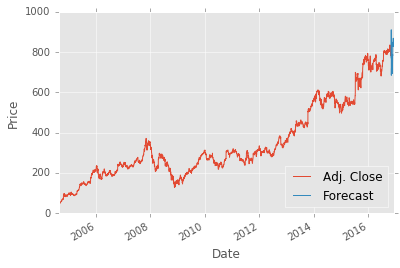

In [9]:
df["Forecast"] = np.nan
last_date=df.iloc[-1].name
print (last_date)
last_unix=last_date.timestamp()
print (last_unix)
one_day=86400
next_unix = last_unix + one_day
for i in forecast_set:
    next_date=datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range (len(df.columns)-1)] + [i]
print (df.tail())
df["Adj. Close"].plot()
df["Forecast"].plot()
plt.legend(loc=4)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()